In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from sodapy import Socrata


# Get Data from NYC Open Data
1. Download restaurant inspection results
2. Create a pandas frame
3. Remove duplicate restaurants

In [2]:
# get New York City Restaurant Inspection Results from NYC Open Data and create dataframe
client = Socrata("data.cityofnewyork.us", None)
results = client.get("43nn-pn8j", limit=500000)
restaurant = pd.DataFrame.from_records(results)


In [3]:
len(restaurant)

210053

In [4]:
# remove duplicate records based on multiple inspections
restaurant = restaurant.drop_duplicates(subset=['camis'])
len(restaurant)

28462

In [5]:
restaurant.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,grade_date
0,50119778,BETTY,Manhattan,193,HENRY STREET,10002,6462204044,American,2023-07-07T00:00:00.000,Violations were cited in the following area(s).,...,Pre-permit (Operational) / Initial Inspection,40.713575444829,-73.987832926701,103,01,000600,1003688,1002850008,MN28,NaN
1,50143876,POOM BAKERS COLLECTIVE,Manhattan,185,GREENWICH STREET,10007,2676488754,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.711783119412,-74.012083781597,101,01,001300,1089309,1000580001,MN25,NaN
2,50144732,NaN,Brooklyn,672,GRAND STREET,11211,3473242125,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.711490763621,-73.945341866351,301,34,049500,3069582,3027880007,BK90,NaN
3,50142028,NaN,Queens,3515,DITMARS BLVD,11105,7187772188,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.774734266491,-73.908718766609,401,22,011300,4016613,4008240164,QN72,NaN
4,50137368,Short Stories,Manhattan,355,BOWERY,10003,6469454636,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.726728713195,-73.991662117529,103,02,003800,1079833,1004590005,MN22,NaN


In [6]:
# aggregate by nta area 
restaurant_nta = restaurant.groupby(['nta','boro']).size().reset_index(name='count')
restaurant_nta


,nta,boro,count
0,BK09,Brooklyn,113
1,BK17,Brooklyn,131
2,BK19,Brooklyn,61
3,BK21,Brooklyn,75
4,BK23,Brooklyn,31
...,...,...,...
189,SI36,Staten Island,51
190,SI37,Staten Island,81
191,SI45,Staten Island,93
192,SI48,Staten Island,6


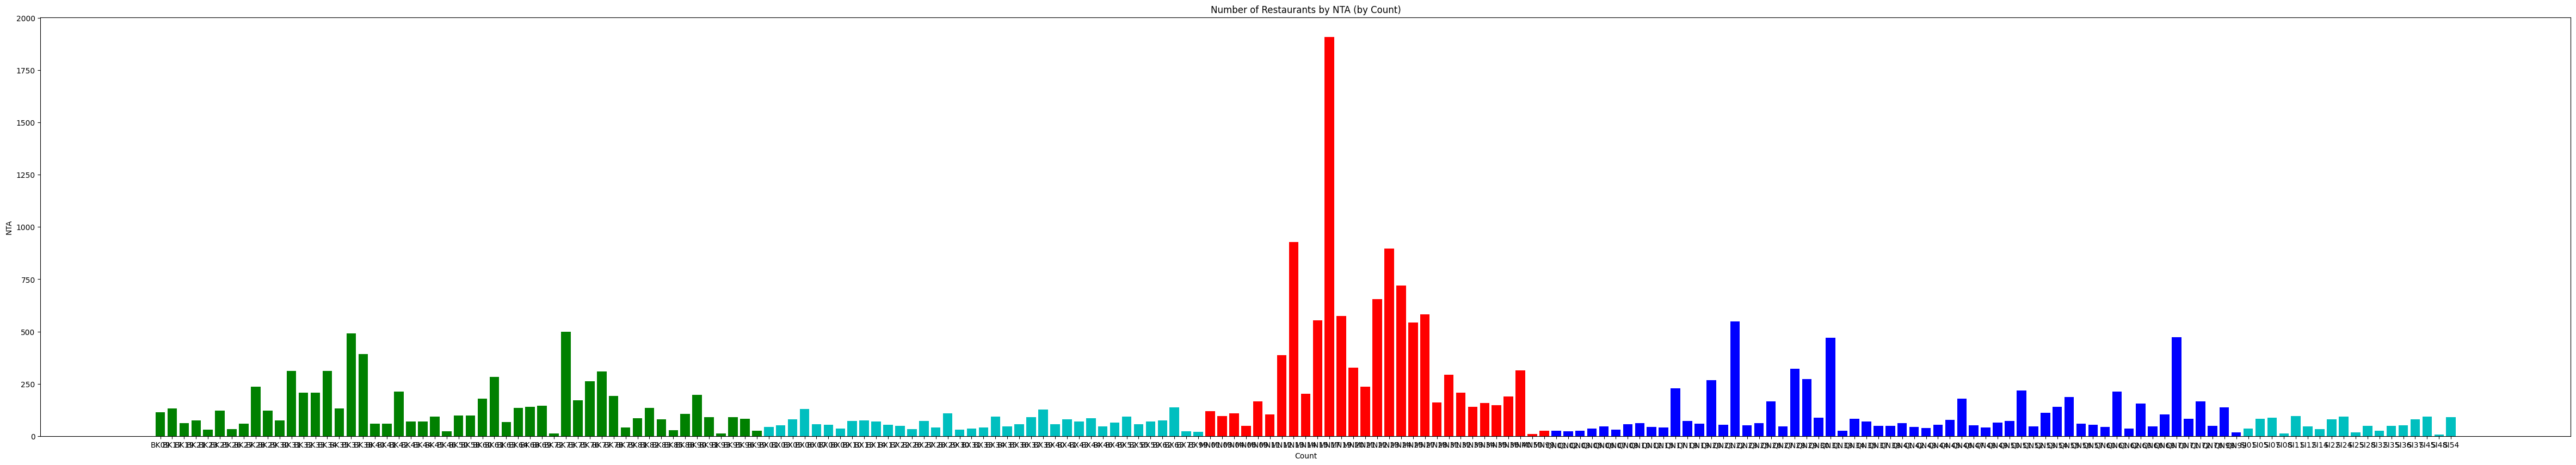

In [7]:
# Create bar chart by nta (neighborhood)
boros = restaurant['boro'].unique()
cmap = colors.ListedColormap(['r', 'g', 'b', 'y', 'c'])

fig, ax = plt.subplots(figsize=(60, 10))

for i, row in restaurant_nta.iterrows():
    color = cmap(boros.tolist().index(row['boro']))
    ax.bar(row['nta'], row['count'], color=color)

ax.set_xlabel('Count')
ax.set_ylabel('NTA')
ax.set_title('Number of Restaurants by NTA (by Count)')
plt.show()

In [8]:
# aggregate by boro 
restaurant_boro = restaurant.groupby(['boro']).size().reset_index(name='count')
restaurant_boro

,boro,count
0,0,11
1,Bronx,2464
2,Brooklyn,7303
3,Manhattan,11039
4,Queens,6603
5,Staten Island,1042


In [9]:
# observe restaurants with no reliable location data
len(restaurant[(restaurant['boro'] == "0") | (restaurant['nta'] == "0") | (restaurant['latitude'] == "0") | (restaurant['longitude'] == "0")])



431

In [10]:
# drop no location data entries
restaurant = restaurant[(restaurant['boro'] != "0") & (restaurant['nta'] != "0") & (restaurant['latitude'] != "0") & (restaurant['longitude'] != "0")]
len(restaurant)

28031

<BarContainer object of 5 artists>

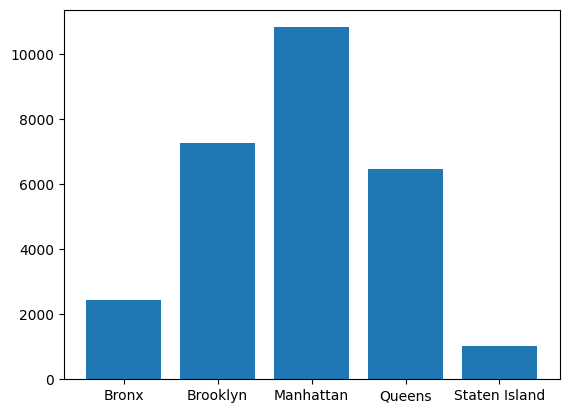

In [11]:
# aggregate by boro and plot a bar chart
restaurant_boro = restaurant.groupby(['boro']).size().reset_index(name='count')
plt.bar(restaurant_boro['boro'],restaurant_boro['count'])

<Axes: xlabel='longitude', ylabel='latitude'>

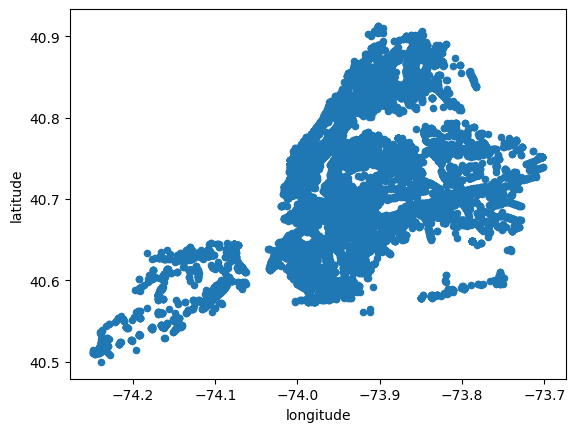

In [13]:
# plot the dataframe
restaurant['latitude'] = pd.to_numeric(restaurant['latitude'], errors='coerce')
restaurant['longitude'] = pd.to_numeric(restaurant['longitude'], errors='coerce')
restaurant.plot(x="longitude", y="latitude", kind="scatter")

In [29]:
# show all cuisine types
restaurant['cuisine_description'].unique()

array(['American', nan, 'Pizza', 'Caribbean', 'Thai', 'Japanese',
       'Chinese', 'Coffee/Tea', 'Hamburgers', 'Other', 'Latin American',
       'Jewish/Kosher', 'Chicken', 'Italian', 'Seafood', 'French',
       'Juice, Smoothies, Fruit Salads', 'Bakery Products/Desserts',
       'Sandwiches', 'Korean', 'Asian/Asian Fusion', 'Indian', 'Spanish',
       'Southeast Asian', 'African', 'Donuts', 'Mediterranean',
       'Barbecue', 'Creole', 'Turkish', 'Mexican', 'Hotdogs/Pretzels',
       'Bangladeshi', 'Tex-Mex', 'Fusion', 'Eastern European', 'Greek',
       'Vegan', 'Bagels/Pretzels', 'Russian', 'Middle Eastern',
       'Frozen Desserts', 'Peruvian', 'Soups', 'Salads', 'German',
       'Tapas', 'Pancakes/Waffles', 'Irish', 'Polish', 'Moroccan',
       'Sandwiches/Salads/Mixed Buffet', 'Vegetarian', 'Continental',
       'Steakhouse', 'Brazilian', 'Afghan', 'Portuguese', 'Pakistani',
       'Scandinavian', 'Ethiopian', 'Bottled Beverages',
       'Fruits/Vegetables', 'Filipino', 'Soul Fo

In [37]:
# remove non-food cuisine types
remove = ['Coffee/Tea','Juice','Smoothies','Frozen Desserts','Bottled Beverages','Fruits/Vegetables','Nuts/Confectionary','Donuts']
restaurant = restaurant[~restaurant['cuisine_description'].isin(remove)]


<BarContainer object of 20 artists>

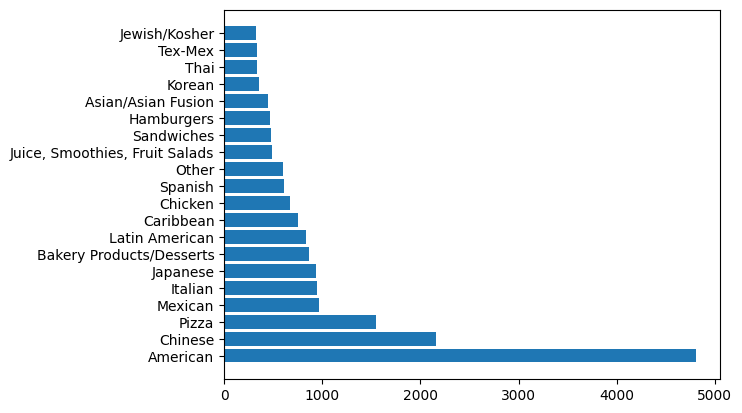

In [38]:
# plot most common 20 cuisine types
cuisine = restaurant.groupby(['cuisine_description']).size().reset_index(name='count')
cuisine = cuisine.sort_values('count', ascending=False)
plt.barh(cuisine.head(20)['cuisine_description'],cuisine.head(20)['count'])


In [39]:
restaurant.to_csv('restaurant.csv', index=False)